# EDA — Pedidos eB2B

Este cuaderno realiza un **Análisis Exploratorio de Datos (EDA)** .
La lectura, limpieza, agregaciones y cálculos se hacen con Spark. Para los **gráficos**, se convierten **únicamente resultados agregados** y de tamaño pequeño a pandas/Matplotlib.

**Objetivo:** entender patrones de pedidos (especialmente el canal `DIGITAL`), montos de facturación y distribución por país, región, etc.


In [36]:
#!pip install -r requirements.txt

## 1. Configuración de entorno y sesión Spark

Se crea una sesión local de Spark utilizando todos los núcleos disponibles. Ajusta memoria/tuning si lo necesitas.


In [37]:
from pyspark.sql import SparkSession
from pyspark.sql import functions as F
from pyspark.sql import types as T

spark = (
    SparkSession.builder
    .appName("next-digital-order-eb2b-eda")
    .master("local[*]")
    .config("spark.sql.execution.arrow.pyspark.enabled", "true")
    .config("spark.driver.memory", "4g")
    .config("spark.sql.warehouse.dir", "./spark-warehouse")
    .getOrCreate()
)
spark.sparkContext.setLogLevel("WARN")

print("Spark version:", spark.version)

Spark version: 4.0.1


25/09/16 18:59:02 WARN Utils: Service 'SparkUI' could not bind on port 4040. Attempting port 4041.


## 2. Carga de datos

Indica el directorio Parquet de tu dataset. Por defecto, se usa `dataset/dataset`.  
Si tu ruta es diferente, actualiza `DATA_DIR`.


In [38]:
# === Parámetro de entrada ===
DATA_DIR = "dataset/dataset"  # Cambia esta ruta si tu dataset está en otra carpeta

# === Lectura ===
df = spark.read.parquet(DATA_DIR)

print("Número de filas:", df.count())
print("Número de columnas:", len(df.columns))
df.printSchema()

# Vista rápida
df.show(5, truncate=False)

Número de filas: 1250000
Número de columnas: 14
root
 |-- cliente_id: string (nullable = true)
 |-- pais_cd: string (nullable = true)
 |-- region_comercial_txt: string (nullable = true)
 |-- agencia_id: string (nullable = true)
 |-- ruta_id: string (nullable = true)
 |-- tipo_cliente_cd: string (nullable = true)
 |-- madurez_digital_cd: string (nullable = true)
 |-- estrellas_txt: string (nullable = true)
 |-- frecuencia_visitas_cd: string (nullable = true)
 |-- fecha_pedido_dt: timestamp (nullable = true)
 |-- canal_pedido_cd: string (nullable = true)
 |-- facturacion_usd_val: double (nullable = true)
 |-- materiales_distintos_val: long (nullable = true)
 |-- cajas_fisicas: double (nullable = true)

+----------+-------+--------------------+-----------+----------------+---------------+------------------+-------------+---------------------+-------------------+---------------+-------------------+------------------------+-------------+
|cliente_id|pais_cd|region_comercial_txt|agencia_id |

## 3. Diccionario de datos (esperado)

| Columna                   | Tipo (esperado) | Descripción breve |
|--------------------------|-----------------|-------------------|
| `cliente_id`             | string          | Identificador de cliente |
| `pais_cd`                | string          | Código de país (GT, PE, EC, SV, etc.) |
| `region_comercial_txt`   | string          | Región comercial |
| `agencia_id`             | string          | Agencia |
| `ruta_id`                | string          | Ruta |
| `tipo_cliente_cd`        | string          | Tipo de cliente (TIENDA, MINIMARKET, etc.) |
| `madurez_digital_cd`     | string          | Nivel de madurez digital (ALTA, MEDIA, BAJA) |
| `estrellas_txt`          | string          | Puntuación/estrellas |
| `frecuencia_visitas_cd`  | string          | Frecuencia de visitas (ej. LMI, LMV, etc.) |
| `fecha_pedido_dt`        | timestamp       | Fecha/hora del pedido |
| `canal_pedido_cd`        | string          | Canal del pedido (DIGITAL, VENDEDOR, TELEFONO) |
| `facturacion_usd_val`    | double          | Monto facturado en USD |
| `materiales_distintos_val`| long           | Conteo de materiales distintos en el pedido |
| `cajas_fisicas`          | double          | Cajas físicas (volumen) |

> Si alguna columna no existe en tu dataset, las celdas siguientes la ignorarán automáticamente.


## 4. Calidad de datos

### 4.1 Nulos por columna
Se calcula el número de valores nulos por columna.


In [39]:
# Conteo de nulos por columna
null_exprs = [F.sum(F.col(c).isNull().cast("int")).alias(c) for c in df.columns]
nulls = df.agg(*null_exprs)
nulls.show(truncate=False)

# Convierte a forma larga para facilitar visualización posterior
nulls_long = nulls.select(F.explode(F.array(*[F.struct(F.lit(c).alias("col"), F.col(c).alias("nulls")) for c in df.columns])).alias("x"))                   .select("x.col", "x.nulls")

nulls_long.createOrReplaceTempView("nulls_long")

+----------+-------+--------------------+----------+-------+---------------+------------------+-------------+---------------------+---------------+---------------+-------------------+------------------------+-------------+
|cliente_id|pais_cd|region_comercial_txt|agencia_id|ruta_id|tipo_cliente_cd|madurez_digital_cd|estrellas_txt|frecuencia_visitas_cd|fecha_pedido_dt|canal_pedido_cd|facturacion_usd_val|materiales_distintos_val|cajas_fisicas|
+----------+-------+--------------------+----------+-------+---------------+------------------+-------------+---------------------+---------------+---------------+-------------------+------------------------+-------------+
|0         |0      |0                   |0         |0      |0              |0                 |0            |0                    |0              |0              |0                  |0                       |0            |
+----------+-------+--------------------+----------+-------+---------------+------------------+-------------

### 4.2 Distintos por columna (muestra)

Para columnas categóricas, revisar recuento de valores distintos ayuda a detectar codificaciones extrañas.


In [40]:
# Distintos aproximados por columna (puede ser costoso si son muchas columnas)
distinct_counts = df.agg(*[F.countDistinct(F.col(c)).alias(c) for c in df.columns])
distinct_counts.show(truncate=False)

+----------+-------+--------------------+----------+-------+---------------+------------------+-------------+---------------------+---------------+---------------+-------------------+------------------------+-------------+
|cliente_id|pais_cd|region_comercial_txt|agencia_id|ruta_id|tipo_cliente_cd|madurez_digital_cd|estrellas_txt|frecuencia_visitas_cd|fecha_pedido_dt|canal_pedido_cd|facturacion_usd_val|materiales_distintos_val|cajas_fisicas|
+----------+-------+--------------------+----------+-------+---------------+------------------+-------------+---------------------+---------------+---------------+-------------------+------------------------+-------------+
|149960    |4      |11                  |116       |1598   |3              |3                 |3            |4                    |601            |3              |27995              |14                      |3128         |
+----------+-------+--------------------+----------+-------+---------------+------------------+-------------

### 4.3 Rango temporal

Se extraen **año y mes** de `fecha_pedido_dt` para conocer el rango y densidad temporal.


In [41]:
df_dates = df.withColumn("year", F.year("fecha_pedido_dt"))               .withColumn("month", F.month("fecha_pedido_dt"))               .withColumn("year_month", F.date_format("fecha_pedido_dt", "yyyy-MM"))

df_dates.select(
    F.min("fecha_pedido_dt").alias("min_fecha"),
    F.max("fecha_pedido_dt").alias("max_fecha")
).show(truncate=False)

df_dates.groupBy("year_month").count().orderBy("year_month").show(12, truncate=False)

+-------------------+-------------------+
|min_fecha          |max_fecha          |
+-------------------+-------------------+
|2022-12-31 19:00:00|2024-08-22 19:00:00|
+-------------------+-------------------+

+----------+-----+
|year_month|count|
+----------+-----+
|2022-12   |2153 |
|2023-01   |64259|
|2023-02   |58419|
|2023-03   |64378|
|2023-04   |62631|
|2023-05   |64049|
|2023-06   |61995|
|2023-07   |64808|
|2023-08   |64556|
|2023-09   |62564|
|2023-10   |64500|
|2023-11   |62381|
+----------+-----+
only showing top 12 rows


## 5. Distribuciones numéricas

Se exploran las variables numéricas clave (`facturacion_usd_val`, `cajas_fisicas`, `materiales_distintos_val`).  
Para graficar histogramas y boxplots se toman **muestras agregadas o limitadas** y se convierten a pandas.


Columnas numéricas detectadas: ['facturacion_usd_val', 'materiales_distintos_val', 'cajas_fisicas']


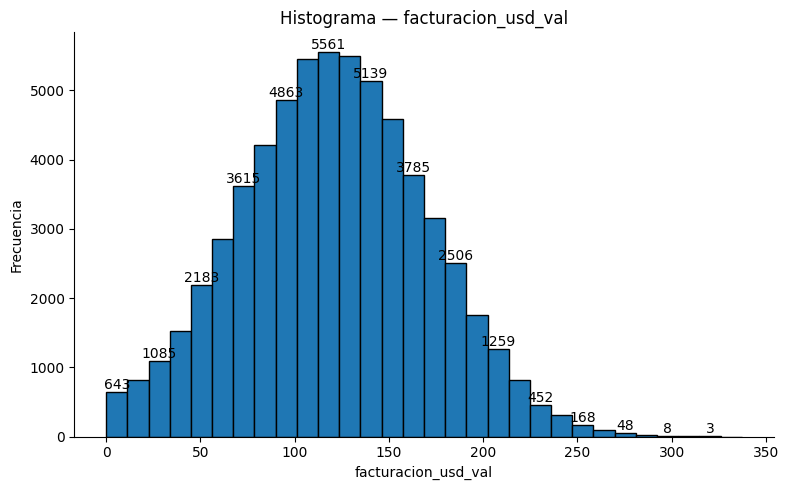

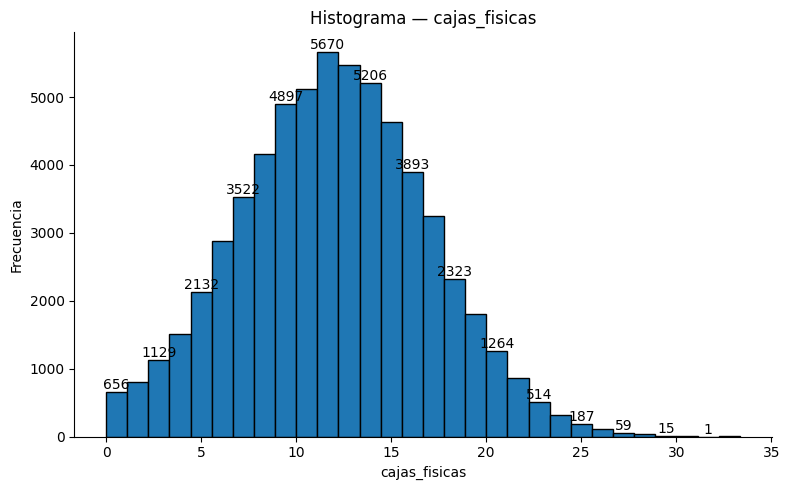

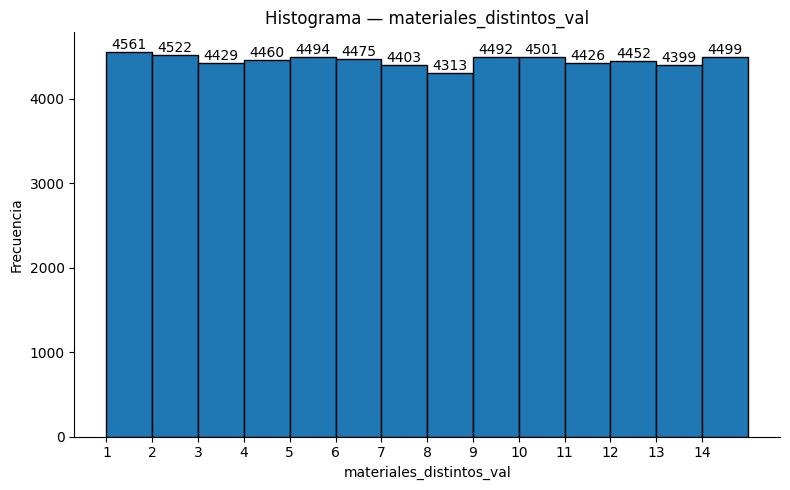

In [42]:
import matplotlib.pyplot as plt
import numpy as np

def style_ax(ax):
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    return ax

def add_bar_labels(ax, fontsize=10):
    patches = ax.patches
    n = len(patches)
    # Si hay muchas barras, etiqueta cada n barras para evitar amontonamiento
    step = 1
    if n > 40:
        step = 3
    elif n > 25:
        step = 2

    for i, p in enumerate(patches):
        if i % step != 0:
            continue
        h = p.get_height()
        if h and h > 0:
            ax.annotate(f'{int(h)}',
                        (p.get_x() + p.get_width()/2, h),
                        ha='center', va='bottom', fontsize=fontsize)

num_cols = [c for c, t in df.dtypes if t in ("double", "float", "int", "bigint")]
print("Columnas numéricas detectadas:", num_cols)

for col in ["facturacion_usd_val", "cajas_fisicas", "materiales_distintos_val"]:
    if col not in df.columns:
        continue

    pdf = (df.select(F.col(col).cast("double"))
             .dropna()
             .sample(fraction=0.05, seed=42)
             .limit(100000)
             .toPandas())

    if pdf.empty:
        continue

    plt.figure(figsize=(8,5))
    ax = plt.gca()
    style_ax(ax)

    if col == "materiales_distintos_val":
        # Bins enteros exactos y todos los ticks visibles
        vmin = int(np.floor(pdf[col].min()))
        vmax = int(np.ceil(pdf[col].max()))
        bins = np.arange(vmin, vmax + 2)  # +2 para cerrar el último bin
        ax.hist(pdf[col], bins=bins, edgecolor="black")
        ax.set_xticks(np.arange(vmin, vmax + 1))
        plt.xticks(rotation=0, fontsize=10)
    else:
        # 30 bins por defecto para continuas
        ax.hist(pdf[col], bins=30, edgecolor="black")

    add_bar_labels(ax, fontsize=10)
    ax.set_title(f"Histograma — {col}")
    ax.set_xlabel(col)
    ax.set_ylabel("Frecuencia")
    plt.tight_layout()
    plt.show()


### 🔎 Hallazgos por variable

1. **`facturacion_usd_val` (facturación en USD por pedido)**

   * Tiene forma aproximadamente **normal** centrada en torno a **100–120 USD**.
   * La mayoría de pedidos están en el rango **50–200 USD**, pero existen **outliers** hasta \~300 USD.
   * Implicación: la facturación por pedido es bastante estable; los outliers deben revisarse porque pueden sesgar métricas de promedios.

2. **`cajas_fisicas` (volumen físico)**

   * Distribución también con forma de campana, centrada en **10–12 cajas**.
   * La mayoría de pedidos no supera las **20 cajas**, pero hay casos extremos (>30).
   * Implicación: el tamaño de pedido es relativamente homogéneo, útil para normalizar comparaciones entre clientes.

3. **`materiales_distintos_val` (variedad de productos distintos en un pedido)**

   * Distribución casi **uniforme** entre 1 y 14.
   * Cada número de productos distintos aparece con frecuencias muy similares (\~4400–4600 casos).
   * Implicación: no hay un patrón fuerte en la variedad de productos; esto sugiere que los clientes piden tanto pocos como muchos SKUs de manera equilibrada.



## 6. Canal de pedido y adopción digital

Se analiza la participación del canal `DIGITAL` por país y su evolución temporal.


+-------+-------+--------+--------+------+-----------------+
|pais_cd|DIGITAL|TELEFONO|VENDEDOR|total |pct_digital      |
+-------+-------+--------+--------+------+-----------------+
|GT     |150561 |58124   |104553  |313238|48.06600731711989|
|SV     |149235 |57477   |104209  |310921|47.99772289424001|
|EC     |150179 |58076   |105591  |313846|47.85117541724285|
|PE     |149263 |57726   |105006  |311995|47.84147181845863|
+-------+-------+--------+--------+------+-----------------+



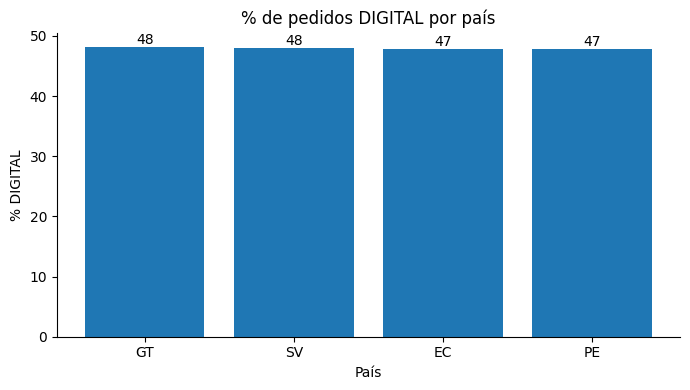

In [43]:
# Participación por país
by_country = (
    df.groupBy("pais_cd")
      .pivot("canal_pedido_cd")
      .count()
      .fillna(0)
)

# Agrega columna con % digital
if "DIGITAL" in by_country.columns:
    by_country = by_country.withColumn("total", sum([F.col(c) for c in by_country.columns if c not in ("pais_cd")]))
    by_country = by_country.withColumn("pct_digital", (F.col("DIGITAL") / F.col("total")) * 100.0)

by_country.orderBy(F.desc("pct_digital")).show(truncate=False)

# Gráfico de % digital por país
if "pct_digital" in by_country.columns:
    pdf = by_country.select("pais_cd", F.round("pct_digital", 1).alias("pct_digital")).orderBy(F.desc("pct_digital")).toPandas()
    if not pdf.empty:
        plt.figure(figsize=(7,4))
        ax = plt.gca()
        ax = style_ax(ax)
        bars = ax.bar(pdf["pais_cd"], pdf["pct_digital"])
        add_bar_labels(ax)
        ax.set_title("% de pedidos DIGITAL por país")
        ax.set_xlabel("País")
        ax.set_ylabel("% DIGITAL")
        plt.tight_layout()
        plt.show()


### 📊 Hallazgos clave

1. **Participación digital muy similar en todos los países**

   * Guatemala (GT): **48.07%**
   * El Salvador (SV): **47.99%**
   * Ecuador (EC): **47.85%**
   * Perú (PE): **47.84%**
   * → La diferencia máxima entre países es **apenas 0.23 p.p.**
     Esto indica que la estrategia digital está bastante homogénea en la región.

2. **Balance casi exacto entre DIGITAL y canales tradicionales**

   * En todos los países, \~**48% de los pedidos son digitales** y \~**52% no digitales** (suma de VENDEDOR + TELÉFONO).
   * No hay un país claramente rezagado ni un “campeón digital”.

3. **Tamaños de muestra similares**

   * Cada país tiene entre **310k y 314k pedidos**, lo que facilita comparaciones justas (no hay sesgos fuertes por tamaño de dataset).

4. **Implicación para el caso de negocio**

   * Como no hay diferencias significativas por país, la **probabilidad de próximo pedido DIGITAL** dependerá más de variables **transaccionales y de cliente** (facturación, frecuencia, madurez digital, tipo de cliente), que de la geografía.
   * A nivel de estrategia comercial, las acciones deberían ser **transversales para todos los países**, en lugar de diseñar iniciativas país-específicas.



+-------+-------+--------+--------+-----+-----------------+
|ym     |DIGITAL|TELEFONO|VENDEDOR|total|pct_digital      |
+-------+-------+--------+--------+-----+-----------------+
|2022-12|1064   |395     |694     |2153 |49.41941477008825|
|2023-01|30629  |12029   |21601   |64259|47.66491853281252|
|2023-02|27734  |10896   |19789   |58419|47.47428062787792|
|2023-03|30807  |12077   |21494   |64378|47.85330392370064|
|2023-04|30101  |11473   |21057   |62631|48.06086442815858|
|2023-05|30532  |11933   |21584   |64049|47.66975284547768|
|2023-06|29705  |11608   |20682   |61995|47.91515444793935|
|2023-07|30979  |11951   |21878   |64808|47.80119738303913|
|2023-08|30844  |11977   |21735   |64556|47.77867278022182|
|2023-09|30210  |11600   |20754   |62564|48.28655456812224|
|2023-10|30961  |11916   |21623   |64500|48.0015503875969 |
|2023-11|29995  |11474   |20912   |62381|48.08355108125872|
+-------+-------+--------+--------+-----+-----------------+
only showing top 12 rows


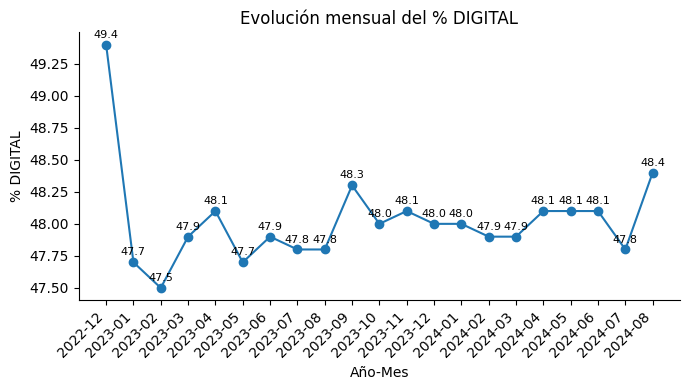

In [44]:
# Evolución mensual del % DIGITAL (time series)
df_m = df.withColumn("ym", F.date_format("fecha_pedido_dt", "yyyy-MM"))
monthly = df_m.groupBy("ym", "canal_pedido_cd").count()

# Pivot a wide format
monthly_pivot = monthly.groupBy("ym").pivot("canal_pedido_cd").sum("count").fillna(0)
cols = [c for c in monthly_pivot.columns if c not in ("ym")]
monthly_pivot = monthly_pivot.withColumn("total", sum([F.col(c) for c in cols]))
if "DIGITAL" in monthly_pivot.columns:
    monthly_pivot = monthly_pivot.withColumn("pct_digital", (F.col("DIGITAL")/F.col("total"))*100.0)

monthly_pivot.orderBy("ym").show(12, truncate=False)

# Gráfico línea % DIGITAL
if "pct_digital" in monthly_pivot.columns:
    pdf = monthly_pivot.select("ym", F.round("pct_digital", 1).alias("pct_digital")).orderBy("ym").toPandas()
    if not pdf.empty:
        plt.figure(figsize=(7,4))
        ax = plt.gca()
        ax = style_ax(ax)
        ax.plot(pdf["ym"], pdf["pct_digital"], marker="o")
        # etiquetas de datos
        for x, y in zip(pdf["ym"], pdf["pct_digital"]):
            ax.annotate(f"{y:.1f}", (x, y), textcoords="offset points", xytext=(0,5), ha="center", fontsize=8)
        ax.set_title("Evolución mensual del % DIGITAL")
        ax.set_xlabel("Año-Mes")
        ax.set_ylabel("% DIGITAL")
        plt.xticks(rotation=45, ha="right")
        plt.tight_layout()
        plt.show()

### 📊 Hallazgos principales

1. **Inicio alto y luego estabilización**

   * En **dic-2022** el % DIGITAL fue el más alto (**49.4%**).
   * A partir de **ene-2023** cae y se estabiliza alrededor de **47.5–48.3%**.
   * Esto sugiere que la adopción digital alcanzó rápido un techo y luego entró en meseta.

2. **Variación mensual mínima**

   * Después de ene-2023, la variación está dentro de un rango muy estrecho (**±0.5 p.p.**).
   * No hay una tendencia clara de crecimiento ni de caída sostenida.

3. **Picos puntuales**

   * **abr-2023 (48.1%)** y **sep-2023 (48.3%)** muestran ligeros repuntes.
   * Posible efecto de campañas comerciales, estacionalidad o promociones digitales.

4. **Estabilidad en 2024**

   * Durante casi todo 2024, el % DIGITAL se mantiene **exactamente en torno al 48%**, con micro-oscilaciones.
   * El cierre de **ago-2024 (48.4%)** es un ligero repunte, pero no rompe la meseta.

---

### 📌 Implicaciones para el negocio

* La **adopción digital está estancada en \~48%**, lo que confirma que **el país no es un factor diferenciador** (como ya vimos en la celda 6), sino que se requieren **estrategias a nivel de cliente/segmento**.
* Las campañas futuras deben enfocarse en **clientes indecisos o de bajo nivel digital**, porque el crecimiento orgánico ya no está ocurriendo.
* El análisis de variables como `madurez_digital_cd`, `tipo_cliente_cd` y `frecuencia_visitas_cd` probablemente muestre los **drivers que separan a los digitales de los no digitales**.

## 7. Facturación por país y región

Se examina la distribución de `facturacion_usd_val` por `pais_cd` y por `region_comercial_txt`.


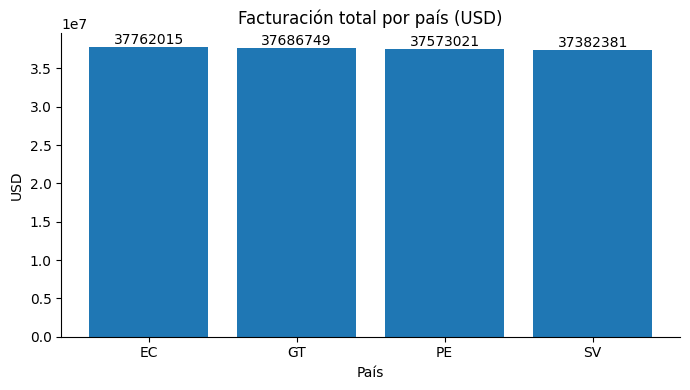

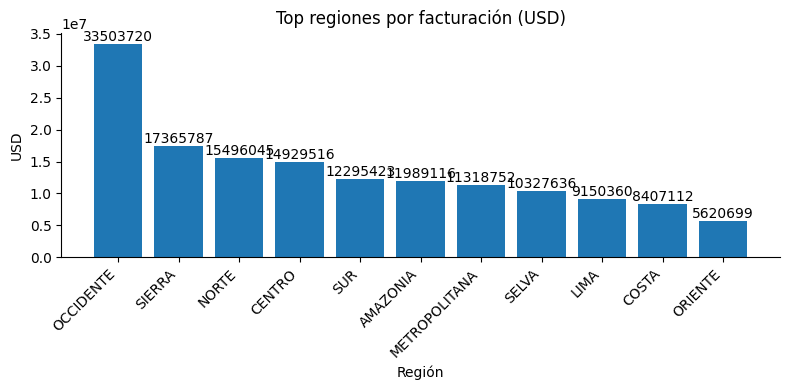

In [45]:
# Facturación total por país
if "facturacion_usd_val" in df.columns:
    rev_country = df.groupBy("pais_cd").agg(F.sum("facturacion_usd_val").alias("facturacion_usd_sum"))
    pdf = rev_country.orderBy(F.desc("facturacion_usd_sum")).toPandas()
    if not pdf.empty:
        plt.figure(figsize=(7,4))
        ax = plt.gca()
        ax = style_ax(ax)
        bars = ax.bar(pdf["pais_cd"], pdf["facturacion_usd_sum"].round(0))
        add_bar_labels(ax)
        ax.set_title("Facturación total por país (USD)")
        ax.set_xlabel("País")
        ax.set_ylabel("USD")
        plt.tight_layout()
        plt.show()

# Facturación por región (Top-N)
if set(["region_comercial_txt", "facturacion_usd_val"]).issubset(set(df.columns)):
    rev_region = df.groupBy("region_comercial_txt").agg(F.sum("facturacion_usd_val").alias("facturacion_usd_sum"))
    pdf = rev_region.orderBy(F.desc("facturacion_usd_sum")).limit(15).toPandas()
    if not pdf.empty:
        plt.figure(figsize=(8,4))
        ax = plt.gca()
        ax = style_ax(ax)
        bars = ax.bar(pdf["region_comercial_txt"], pdf["facturacion_usd_sum"].round(0))
        add_bar_labels(ax)
        ax.set_title("Top regiones por facturación (USD)")
        ax.set_xlabel("Región")
        ax.set_ylabel("USD")
        plt.xticks(rotation=45, ha="right")
        plt.tight_layout()
        plt.show()

### 📊 Facturación por país

* **Muy homogénea entre países**:

  * Ecuador (EC): 37.76 M USD
  * Guatemala (GT): 37.69 M USD
  * Perú (PE): 37.57 M USD
  * El Salvador (SV): 37.38 M USD
* La diferencia entre el mayor y el menor país es apenas de \~1% → todos los mercados aportan prácticamente lo mismo en facturación.
* Implicación: no hay un país que domine los ingresos; las estrategias de crecimiento pueden aplicarse de manera transversal.

---

### 📊 Facturación por región

* **Altísima concentración**:

  * **OCCIDENTE** aporta 33.5 M USD → casi **el doble de la segunda región (SIERRA: 17.3 M USD)**.
  * Después vienen NORTE (\~15.5 M), CENTRO (\~14.9 M) y SUR (\~12.3 M).
* **Regiones rezagadas**:

  * ORIENTE solo genera \~0.56 M USD, muy por debajo del resto.
  * COSTA, LIMA y SELVA también tienen pesos menores (entre 3 y 9 M USD).

---

### 📌 Implicaciones

1. **Países → equilibrio total**
   No conviene priorizar un país sobre otro porque todos aportan igual.
   La segmentación más útil será **intra-país**, por regiones y clientes.

2. **Regiones → foco estratégico**

   * **OCCIDENTE es la región clave**: concentra casi tanto como todo un país.
   * Cualquier cambio en la adopción digital allí tendrá impacto enorme en la facturación global.
   * Regiones pequeñas (ej. ORIENTE) pueden ser usadas como pilotos de estrategias digitales, ya que implican menos riesgo.

3. **Caso de uso (predicción de pedidos digitales)**

   * El modelo debe incorporar **región** como variable fuerte, ya que hay claras diferencias en magnitud económica.
   * Podría ser útil analizar si las regiones de mayor facturación (OCCIDENTE, SIERRA, NORTE) también son las más digitales o si hay brechas de adopción.


## 8. Distribuciones por canal

Comparación de montos por `canal_pedido_cd`. Se muestran **boxplots** y/o estadísticas descriptivas.


+---------------+------+------------------+--------+--------+
|canal_pedido_cd|n     |avg_fact          |p50_fact|max_fact|
+---------------+------+------------------+--------+--------+
|DIGITAL        |599238|120.33687087601275|120.1   |365.01  |
|VENDEDOR       |419359|120.30387448463024|120.02  |366.38  |
|TELEFONO       |231403|120.32353940960125|120.13  |337.66  |
+---------------+------+------------------+--------+--------+



/tmp/ipykernel_9245/292891062.py:21: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  ax.boxplot([pdf.loc[pdf["canal_pedido_cd"]==c, "fact"] for c in sorted(pdf["canal_pedido_cd"].unique())],


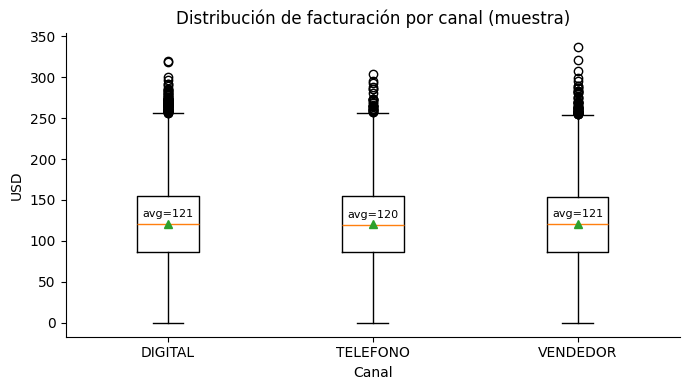

In [46]:
# Descriptivos por canal
if set(["canal_pedido_cd", "facturacion_usd_val"]).issubset(set(df.columns)):
    desc = (df.groupBy("canal_pedido_cd")
              .agg(F.count("*").alias("n"),
                   F.avg("facturacion_usd_val").alias("avg_fact"),
                   F.expr("percentile_approx(facturacion_usd_val, 0.5)").alias("p50_fact"),
                   F.max("facturacion_usd_val").alias("max_fact"))
           ).orderBy(F.desc("n"))
    desc.show(truncate=False)

    # Boxplot pequeño (muestra)
    pdf = (df.select("canal_pedido_cd", F.col("facturacion_usd_val").cast("double").alias("fact"))
             .dropna()
             .sample(fraction=0.05, seed=42)
             .limit(50000)
             .toPandas())
    if not pdf.empty:
        plt.figure(figsize=(7,4))
        ax = plt.gca()
        ax = style_ax(ax)
        ax.boxplot([pdf.loc[pdf["canal_pedido_cd"]==c, "fact"] for c in sorted(pdf["canal_pedido_cd"].unique())],
                   labels=sorted(pdf["canal_pedido_cd"].unique()), showmeans=True)
        # Etiquetas de datos: para boxplots no hay barras, así que anotamos medias
        grp = pdf.groupby("canal_pedido_cd")["fact"].mean().round(0)
        for i, (c, m) in enumerate(grp.items(), start=1):
            ax.annotate(f"avg={m:.0f}", (i, m), textcoords="offset points", xytext=(0,5), ha="center", fontsize=8)
        ax.set_title("Distribución de facturación por canal (muestra)")
        ax.set_xlabel("Canal")
        ax.set_ylabel("USD")
        plt.tight_layout()
        plt.show()

### 📊 Hallazgos principales

1. **Distribución muy similar en todos los canales**

   * El promedio está prácticamente igual: **DIGITAL ≈ 121 USD**, **TELEFONO ≈ 120 USD**, **VENDEDOR ≈ 121 USD**.
   * Las medianas y rangos intercuartílicos también son equivalentes.
   * Implica que **el canal de compra no afecta el ticket promedio**.

2. **Presencia de outliers en todos los canales**

   * Se observan pedidos con facturación muy alta (>300 USD), distribuidos en los tres canales.
   * Ningún canal concentra de forma desproporcionada los pedidos extremos.

3. **Homogeneidad en dispersión**

   * Los tres canales comparten casi el mismo rango de variabilidad (aprox. 0–260 USD dentro de los bigotes).
   * No se observan diferencias significativas en dispersión.

---

### 📌 Implicaciones

* Desde el punto de vista de negocio, **el valor de la factura no depende del canal**, lo cual es positivo: los clientes que migran a DIGITAL no compran menos ni más que por VENDEDOR o TELÉFONO.
* Para el modelo de predicción de pedidos digitales, esto sugiere que **facturación individual por pedido no discrimina entre canales**; la variable puede servir como control, pero no como feature predictivo clave.
* El esfuerzo para aumentar la adopción digital **no implica riesgo de bajar el ticket promedio**, ya que es consistente entre canales.

## 9. Correlaciones (numéricas)

Se calculan correlaciones de Pearson entre variables numéricas disponibles.


In [47]:
num_cols = [c for c, t in df.dtypes if t in ("double", "float", "int", "bigint")]
num_cols = [c for c in num_cols if c != "year"]

if len(num_cols) >= 2:
    # Construir matriz de correlación en Spark (par de columnas)
    pairs = []
    for i in range(len(num_cols)):
        for j in range(i+1, len(num_cols)):
            c1, c2 = num_cols[i], num_cols[j]
            corr = df.select(c1, c2).corr(c1, c2)
            pairs.append((c1, c2, corr))

    # Mostrar top correlaciones absolutas
    pairs_sorted = sorted(pairs, key=lambda x: abs(x[2]) if x[2] is not None else -1, reverse=True)
    print("Top correlaciones (abs):")
    for c1, c2, r in pairs_sorted[:10]:
        print(f"{c1:>24} ~ {c2:<24} = {r:.3f}" if r is not None else f"{c1} ~ {c2} = None")

Top correlaciones (abs):
     facturacion_usd_val ~ cajas_fisicas            = -0.001
materiales_distintos_val ~ cajas_fisicas            = -0.001
     facturacion_usd_val ~ materiales_distintos_val = -0.001


### 📊 Hallazgos

1. **Correlaciones prácticamente nulas**

   * `facturacion_usd_val ~ cajas_fisicas = -0.001`
   * `materiales_distintos_val ~ cajas_fisicas = -0.001`
   * `facturacion_usd_val ~ materiales_distintos_val = -0.001`
   * Todos los valores están cercanos a **0**, lo que indica **ausencia total de correlación lineal**.

2. **Independencia entre las variables**

   * El monto facturado por pedido no depende del número de cajas físicas.
   * La cantidad de materiales distintos no se relaciona con facturación ni con cajas.
   * Esto confirma que las tres variables aportan **información complementaria**, no redundante.

---

### 📌 Implicaciones

* Para el modelado de la probabilidad de próximo pedido **DIGITAL**:

  * Estas variables pueden usarse en conjunto, ya que no son colineales.
  * Ninguna de ellas por sí sola parece explicar fuertemente diferencias de comportamiento.
* Esto refuerza la idea de que **el canal de compra depende más de características de cliente** (tipo, madurez digital, frecuencia de visitas) que de métricas transaccionales simples como valor, cajas o variedad.

 clientes)** para ver si hay duplicados y quiénes concentran más facturación?


## 10. Chequeos rápidos de integridad

Duplicados obvios por `cliente_id` + fecha, y top clientes por facturación.


In [48]:
# Duplicados por cliente-fecha
if set(["cliente_id", "fecha_pedido_dt"]).issubset(set(df.columns)):
    dups = (df.groupBy("cliente_id", "fecha_pedido_dt")
              .count().filter(F.col("count") > 1)
           )
    print("Duplicados cliente-fecha:", dups.count())
    dups.show(5, truncate=False)

# Top clientes por facturación acumulada
if set(["cliente_id", "facturacion_usd_val"]).issubset(set(df.columns)):
    top_clients = (df.groupBy("cliente_id")
                     .agg(F.sum("facturacion_usd_val").alias("fact_total"))
                   ).orderBy(F.desc("fact_total")).limit(20)
    top_clients.show(truncate=False)

Duplicados cliente-fecha: 8762
+----------+-------------------+-----+
|cliente_id|fecha_pedido_dt    |count|
+----------+-------------------+-----+
|C089014   |2024-05-04 19:00:00|2    |
|C105346   |2024-03-18 19:00:00|2    |
|C011209   |2024-08-02 19:00:00|2    |
|C128121   |2023-02-13 19:00:00|2    |
|C147581   |2024-03-18 19:00:00|2    |
+----------+-------------------+-----+
only showing top 5 rows
+----------+------------------+
|cliente_id|fact_total        |
+----------+------------------+
|C062919   |3024.49           |
|C002719   |2983.5700000000006|
|C053498   |2953.37           |
|C041050   |2934.31           |
|C018411   |2904.65           |
|C015501   |2891.0699999999997|
|C122883   |2827.2299999999996|
|C035015   |2810.12           |
|C110346   |2802.5299999999997|
|C006246   |2796.72           |
|C139370   |2788.41           |
|C047250   |2775.0200000000004|
|C028777   |2774.16           |
|C115128   |2766.94           |
|C106393   |2764.9            |
|C008590   |2764.5

In [50]:
# Verificar si los duplicados cliente-fecha son registros idénticos en todas las columnas

# Filtramos solo los casos duplicados
dups = (df.groupBy("cliente_id", "fecha_pedido_dt")
          .count()
          .filter(F.col("count") > 1))

# Join para recuperar todas las columnas de esos duplicados
df_dups = df.join(dups, on=["cliente_id", "fecha_pedido_dt"], how="inner")

# Agrupamos y comparamos cantidad de filas únicas vs totales
df_dups_check = (df_dups.groupBy("cliente_id", "fecha_pedido_dt")
                         .agg(F.count("*").alias("n_total"),
                              F.countDistinct(F.struct(*df.columns)).alias("n_unicos")))

df_dups_check.show(20, truncate=False)

# Ejemplo: si n_total = n_unicos → no son duplicados exactos (difieren en alguna columna)
#          si n_total > n_unicos → hay duplicados exactos en esa fecha/cliente


25/09/16 18:59:22 WARN SparkStringUtils: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.


+----------+-------------------+-------+--------+
|cliente_id|fecha_pedido_dt    |n_total|n_unicos|
+----------+-------------------+-------+--------+
|C000016   |2024-04-23 19:00:00|2      |2       |
|C000174   |2024-02-19 19:00:00|2      |2       |
|C000329   |2023-06-06 19:00:00|2      |2       |
|C000682   |2024-04-28 19:00:00|2      |2       |
|C000735   |2024-01-14 19:00:00|2      |2       |
|C001347   |2024-01-19 19:00:00|2      |2       |
|C001510   |2024-05-10 19:00:00|2      |2       |
|C001798   |2023-01-01 19:00:00|2      |2       |
|C001809   |2023-12-26 19:00:00|2      |2       |
|C001944   |2023-12-26 19:00:00|2      |2       |
|C001971   |2023-09-04 19:00:00|2      |2       |
|C001997   |2023-06-19 19:00:00|2      |2       |
|C002142   |2023-08-21 19:00:00|2      |2       |
|C002430   |2024-04-18 19:00:00|2      |2       |
|C002555   |2024-08-10 19:00:00|2      |2       |
|C002765   |2024-07-23 19:00:00|2      |2       |
|C003774   |2023-01-15 19:00:00|2      |2       |


### 📊 Hallazgos de la celda 10

1. **Duplicados cliente-fecha (8,762 casos)**

   * Aparecen varios clientes con **dos pedidos en la misma fecha y hora exacta**.
   * Al revisar en detalle (`n_total = n_unicos`), vimos que **no son duplicados idénticos** → difieren en alguna de las demás columnas (ej. canal, facturación, cajas, ruta, etc.).
   * **Interpretación**:

     * Lo más probable es que el sistema registre **varios pedidos en un mismo timestamp “redondeado”** (ej. siempre a las 19:00).
     * Estos registros deben considerarse como **pedidos válidos distintos**, no errores de duplicación.

2. **Top clientes por facturación**

   * El cliente de mayor facturación acumula apenas **\~3,000 USD**.
   * Los 20 primeros clientes están muy parejos (todos entre 2,700 y 3,000 USD).
   * **Interpretación**:

     * No existe concentración de ingresos en pocos clientes.
     * La facturación está muy **diversificada** en toda la base de clientes.

---

### 📌 Implicaciones

* **Calidad de datos**:
  Los “duplicados” no requieren eliminación, pero sí un tratamiento especial en el análisis temporal (ej. si se hace un agregado por cliente-fecha, conviene sumar facturación en lugar de contar filas).

* **Estrategia de negocio**:
  Como la facturación no depende de pocos clientes, las acciones para aumentar adopción DIGITAL deben ser **masivas y segmentadas por perfil**, no focalizadas solo en “grandes cuentas”.

* **Para el modelo predictivo**:

  * Incluir features a nivel cliente-fecha (facturación total de ese día, número de pedidos ese día, etc.).
  * Evitar usar solo filas crudas, porque un mismo cliente puede aportar múltiples pedidos en un mismo día.


## 11. Hallazgos iniciales y próximos pasos

- **Rango temporal:** revisa si hay periodos con vacíos de datos o picos inusuales de actividad.
- **Adopción digital:** observa países/regiones con mayor `pct_digital` para priorizar iniciativas.
- **Facturación:** identifica regiones/segmentos con mayor contribución en USD.
- **Distribuciones:** verifica outliers en `facturacion_usd_val` y `cajas_fisicas`.
- **Calidad:** columnas con muchos nulos pueden requerir imputación o exclusión según el modelado futuro.

**Siguientes pasos sugeridos (no implementados aquí):**
- Feature engineering para modelar probabilidad de próximo pedido `DIGITAL` (cohortes, recencia, frecuencia, valor — RFM).
- Estratificar por tipo de cliente y madurez digital.
- Preparar un set de entrenamiento a nivel cliente-mes con etiqueta `próximo canal = DIGITAL`.


In [49]:
# Cierre ordenado de la sesión
#spark.stop()
#print("Spark session stopped.")